# Sandbox for playing around with heading-based segmentation, etc.

From Katy, with cosmetic tweaks by Emilio

In [6]:
import movingpandas as mpd
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import Point
import pandas as pd
import numpy as np
import hvplot.pandas
import holoviews as hv

In [7]:
mpd.__version__

'0.2.rc2'

In [8]:
file = 'ooinhdeep_points.geojson'
gdf = gpd.read_file(file)
gdf.head()

,id,datetime_start,datetime_end,direction,dive_nbr_start,dive_nbr_end,glider_id,deployment_id,data_url,longitude,latitude,geometry
0,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.30895,44.65061,POINT (-124.30895 44.65061)
1,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.30634,44.65065,POINT (-124.30634 44.65065)
2,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.31882,44.64663,POINT (-124.31882 44.64663)
3,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32215,44.64606,POINT (-124.32215 44.64606)
4,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32525,44.64547,POINT (-124.32525 44.64547)


In [9]:
gdf.hvplot()

:Points   [x,y]

In [30]:
#Shifting dataframes to apply bearing calculation. This accounts for the fact that 
#https://gist.github.com/jeromer/2005586
def bearing(gdf):
    from numpy import sin, cos, arctan2
    #Take difference between i and i+1 rows, we get a deltalon column
    deltalon = np.deg2rad(gdf['longitude'].diff(1).shift(-1))
    #Move i+1 to ith row, now we have our lat2 column
    lat2 = np.deg2rad(gdf.shift(-1)['latitude'])
    #Keep rows the same, this is our lat1 column
    lat1 = np.deg2rad(gdf['latitude'])

    x0 = sin(deltalon)*cos(lat2)
    x1 = cos(lat1)*sin(lat2) - sin(lat1)*cos(lat2)*cos(deltalon)
    bearing = arctan2(x0, x1)
    return bearing

In [31]:
gdf['bearing'] = bearing(gdf)

In [32]:
def iterative_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
            k+=1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                j+=1 #Start a new trajectory label
        start_value = row[criterion] #Update comparison value. This method is more robust to changes in curvature
        #that may not represent a new trajectory
        trajectory_id.append(j)
    gdf['traj_id'] = trajectory_id
    return gdf

In [33]:
def direction_segmentation(gdf, criterion, tol):
    """
    gdf is the GeoDataFrame with tracks that you're interested in
    criterion is a column name in the gdf that you're using to segment — for example, angle if you're looking
        at changes in heading, or speed
    tol is the tolerance to a given criterion. For example, a tolerance of .3 means that a change of .3
        in criterion value between two rows will be allowed
    """
    trajectory_id = []
    if criterion == 'bearing':  #Dealing with unit-circle angle repeats.(Range of arctan2 function is from -pi to pi)
        angle_adj = lambda a: (a + np.pi)%(2*np.pi) - np.pi
        tol_func = lambda a, b: abs(angle_adj(a - b))
    else:
        tol_func = lambda a, b: abs(a - b)
    j = 0 #i.e., the first trajectory
    k = 0 #Keep track of iterations to identify the first row. This solves the problem where row indices don't start from 0
    for i, row in gdf.iterrows():
        #Assign starting value for the criterion
        if k == 0:
            start_value = row[criterion]
            k+=1
        else:
            if tol_func(start_value, row[criterion]) < tol:
                pass
            elif tol_func(start_value, row[criterion]) >= tol:
                start_angle = row[criterion] #only change starting angle if we're starting a new trajectory
                j+=1 #Start a new trajectory label
         #Update 
        trajectory_id.append(j)
    gdf['traj_id'] = trajectory_id
    return gdf

In [34]:
#Looking at output of iterative_segmentation with a tolerance of 0.5
seg_gdf = iterative_segmentation(gdf, 'bearing', .5)
print(f"Number of individual trajectories is {np.max(seg_gdf['traj_id'])}")

Number of individual trajectories is 531


In [35]:
seg_gdf.head()

,id,datetime_start,datetime_end,direction,dive_nbr_start,dive_nbr_end,glider_id,deployment_id,data_url,longitude,latitude,geometry,bearing,traj_id
0,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.30895,44.65061,POINT (-124.30895 44.65061),1.549241,0
1,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.30634,44.65065,POINT (-124.30634 44.65065),-1.995876,1
2,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.31882,44.64663,POINT (-124.31882 44.64663),-1.806881,1
3,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32215,44.64606,POINT (-124.32215 44.64606),-1.832165,1
4,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32525,44.64547,POINT (-124.32525 44.64547),-1.830912,1


(-128.19414, -123.97586, 44.4746975, 44.7416125)

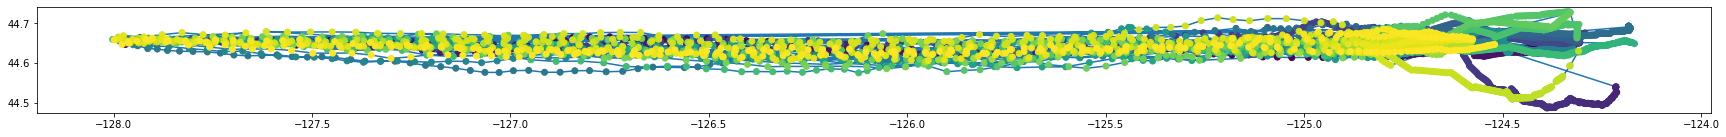

In [36]:
#Plot all output on scaled axis, to get a better sense of "true" angles
plt.figure(figsize = (30,5))
plt.plot(seg_gdf['longitude'], seg_gdf['latitude'], zorder = 0)
plt.scatter(seg_gdf['longitude'], seg_gdf['latitude'], c = seg_gdf['traj_id'])
plt.axis('scaled')

In [37]:
traj_collection = mpd.TrajectoryCollection(seg_gdf, 'traj_id')
plot = traj_collection.hvplot()
#hvplot.save(plot, 'gliders.html')
plot

:Overlay
   .Tiles.I        :Tiles   [x,y]
   .Path.I         :Path   [Longitude,Latitude]
   .Path.II        :Path   [Longitude,Latitude]
   .Path.III       :Path   [Longitude,Latitude]
   .Path.IV        :Path   [Longitude,Latitude]
   .Path.V         :Path   [Longitude,Latitude]
   .Path.VI        :Path   [Longitude,Latitude]
   .Path.VII       :Path   [Longitude,Latitude]
   .Path.VIII      :Path   [Longitude,Latitude]
   .Path.IX        :Path   [Longitude,Latitude]
   .Path.X         :Path   [Longitude,Latitude]
   .Path.XI        :Path   [Longitude,Latitude]
   .Path.XII       :Path   [Longitude,Latitude]
   .Path.XIII      :Path   [Longitude,Latitude]
   .Path.XIV       :Path   [Longitude,Latitude]
   .Path.XV        :Path   [Longitude,Latitude]
   .Path.XVI       :Path   [Longitude,Latitude]
   .Path.XVII      :Path   [Longitude,Latitude]
   .Path.XVIII     :Path   [Longitude,Latitude]
   .Path.XIX       :Path   [Longitude,Latitude]
   .Path.XX        :Path   [Longitude,Latitude]
   .Path.XXI       :Path   [Longitude,Latitude]
   .Path.XXII      :Path   [Longitude,Latitude]
   .Path.XXIII     :Path   [Longitude,Latitude]
   .Path.XXIV      :Path   [Longitude,Latitude]
   .Path.XXV       :Path   [Longitude,Latitude]
   .Path.XXVI      :Path   [Longitude,Latitude]
   .Path.XXVII     :Path   [Longitude,Latitude]
   .Path.XXVIII    :Path   [Longitude,Latitude]
   .Path.XXIX      :Path   [Longitude,Latitude]
   .Path.XXX       :Path   [Longitude,Latitude]
   .Path.XXXI      :Path   [Longitude,Latitude]
   .Path.XXXII     :Path   [Longitude,Latitude]
   .Path.XXXIII    :Path   [Longitude,Latitude]
   .Path.XXXIV     :Path   [Longitude,Latitude]
   .Path.XXXV      :Path   [Longitude,Latitude]
   .Path.XXXVI     :Path   [Longitude,Latitude]
   .Path.XXXVII    :Path   [Longitude,Latitude]
   .Path.XXXVIII   :Path   [Longitude,Latitude]
   .Path.XXXIX     :Path   [Longitude,Latitude]
   .Path.XL        :Path   [Longitude,Latitude]
   .Path.XLI       :Path   [Longitude,Latitude]
   .Path.XLII      :Path   [Longitude,Latitude]
   .Path.XLIII     :Path   [Longitude,Latitude]
   .Path.XLIV      :Path   [Longitude,Latitude]
   .Path.XLV       :Path   [Longitude,Latitude]
   .Path.XLVI      :Path   [Longitude,Latitude]
   .Path.XLVII     :Path   [Longitude,Latitude]
   .Path.XLVIII    :Path   [Longitude,Latitude]
   .Path.XLIX      :Path   [Longitude,Latitude]
   .Path.L         :Path   [Longitude,Latitude]
   .Path.LI        :Path   [Longitude,Latitude]
   .Path.LII       :Path   [Longitude,Latitude]
   .Path.LIII      :Path   [Longitude,Latitude]
   .Path.LIV       :Path   [Longitude,Latitude]
   .Path.LV        :Path   [Longitude,Latitude]
   .Path.LVI       :Path   [Longitude,Latitude]
   .Path.LVII      :Path   [Longitude,Latitude]
   .Path.LVIII     :Path   [Longitude,Latitude]
   .Path.LIX       :Path   [Longitude,Latitude]
   .Path.LX        :Path   [Longitude,Latitude]
   .Path.LXI       :Path   [Longitude,Latitude]
   .Path.LXII      :Path   [Longitude,Latitude]
   .Path.LXIII     :Path   [Longitude,Latitude]
   .Path.LXIV      :Path   [Longitude,Latitude]
   .Path.LXV       :Path   [Longitude,Latitude]
   .Path.LXVI      :Path   [Longitude,Latitude]
   .Path.LXVII     :Path   [Longitude,Latitude]
   .Path.LXVIII    :Path   [Longitude,Latitude]
   .Path.LXIX      :Path   [Longitude,Latitude]
   .Path.LXX       :Path   [Longitude,Latitude]
   .Path.LXXI      :Path   [Longitude,Latitude]
   .Path.LXXII     :Path   [Longitude,Latitude]
   .Path.LXXIII    :Path   [Longitude,Latitude]
   .Path.LXXIV     :Path   [Longitude,Latitude]
   .Path.LXXV      :Path   [Longitude,Latitude]
   .Path.LXXVI     :Path   [Longitude,Latitude]
   .Path.LXXVII    :Path   [Longitude,Latitude]
   .Path.LXXVIII   :Path   [Longitude,Latitude]
   .Path.LXXIX     :Path   [Longitude,Latitude]
   .Path.LXXX      :Path   [Longitude,Latitude]
   .Path.LXXXI     :Path   [Longitude,Latitude]
   .Path.LXXXII    :Path   [Longitude,Latitude]
   .Path.LXXXIII   :P

In [38]:
#Looking at output of direction_segmentation
#Only difference between the two is that direction_segmentation constrains all trajectories based on the starting
#angle of the trajectory, while iterative_segmentation updates the angle every time a point is added. The former
#may be better for straight-line trajectories, and the latter is probably better if curving/sinuous trajectories
#are present
seg_gdf1 = direction_segmentation(gdf, 'bearing', .5)
print(f"Number of individual trajectories is {np.max(seg_gdf['traj_id'])}")

Number of individual trajectories is 3039


In [39]:
traj_collection1 = mpd.TrajectoryCollection(seg_gdf1, 'traj_id')
traj_collection.hvplot()

:Overlay
   .Tiles.I        :Tiles   [x,y]
   .Path.I         :Path   [Longitude,Latitude]
   .Path.II        :Path   [Longitude,Latitude]
   .Path.III       :Path   [Longitude,Latitude]
   .Path.IV        :Path   [Longitude,Latitude]
   .Path.V         :Path   [Longitude,Latitude]
   .Path.VI        :Path   [Longitude,Latitude]
   .Path.VII       :Path   [Longitude,Latitude]
   .Path.VIII      :Path   [Longitude,Latitude]
   .Path.IX        :Path   [Longitude,Latitude]
   .Path.X         :Path   [Longitude,Latitude]
   .Path.XI        :Path   [Longitude,Latitude]
   .Path.XII       :Path   [Longitude,Latitude]
   .Path.XIII      :Path   [Longitude,Latitude]
   .Path.XIV       :Path   [Longitude,Latitude]
   .Path.XV        :Path   [Longitude,Latitude]
   .Path.XVI       :Path   [Longitude,Latitude]
   .Path.XVII      :Path   [Longitude,Latitude]
   .Path.XVIII     :Path   [Longitude,Latitude]
   .Path.XIX       :Path   [Longitude,Latitude]
   .Path.XX        :Path   [Longitude,Latitude]
   .Path.XXI       :Path   [Longitude,Latitude]
   .Path.XXII      :Path   [Longitude,Latitude]
   .Path.XXIII     :Path   [Longitude,Latitude]
   .Path.XXIV      :Path   [Longitude,Latitude]
   .Path.XXV       :Path   [Longitude,Latitude]
   .Path.XXVI      :Path   [Longitude,Latitude]
   .Path.XXVII     :Path   [Longitude,Latitude]
   .Path.XXVIII    :Path   [Longitude,Latitude]
   .Path.XXIX      :Path   [Longitude,Latitude]
   .Path.XXX       :Path   [Longitude,Latitude]
   .Path.XXXI      :Path   [Longitude,Latitude]
   .Path.XXXII     :Path   [Longitude,Latitude]
   .Path.XXXIII    :Path   [Longitude,Latitude]
   .Path.XXXIV     :Path   [Longitude,Latitude]
   .Path.XXXV      :Path   [Longitude,Latitude]
   .Path.XXXVI     :Path   [Longitude,Latitude]
   .Path.XXXVII    :Path   [Longitude,Latitude]
   .Path.XXXVIII   :Path   [Longitude,Latitude]
   .Path.XXXIX     :Path   [Longitude,Latitude]
   .Path.XL        :Path   [Longitude,Latitude]
   .Path.XLI       :Path   [Longitude,Latitude]
   .Path.XLII      :Path   [Longitude,Latitude]
   .Path.XLIII     :Path   [Longitude,Latitude]
   .Path.XLIV      :Path   [Longitude,Latitude]
   .Path.XLV       :Path   [Longitude,Latitude]
   .Path.XLVI      :Path   [Longitude,Latitude]
   .Path.XLVII     :Path   [Longitude,Latitude]
   .Path.XLVIII    :Path   [Longitude,Latitude]
   .Path.XLIX      :Path   [Longitude,Latitude]
   .Path.L         :Path   [Longitude,Latitude]
   .Path.LI        :Path   [Longitude,Latitude]
   .Path.LII       :Path   [Longitude,Latitude]
   .Path.LIII      :Path   [Longitude,Latitude]
   .Path.LIV       :Path   [Longitude,Latitude]
   .Path.LV        :Path   [Longitude,Latitude]
   .Path.LVI       :Path   [Longitude,Latitude]
   .Path.LVII      :Path   [Longitude,Latitude]
   .Path.LVIII     :Path   [Longitude,Latitude]
   .Path.LIX       :Path   [Longitude,Latitude]
   .Path.LX        :Path   [Longitude,Latitude]
   .Path.LXI       :Path   [Longitude,Latitude]
   .Path.LXII      :Path   [Longitude,Latitude]
   .Path.LXIII     :Path   [Longitude,Latitude]
   .Path.LXIV      :Path   [Longitude,Latitude]
   .Path.LXV       :Path   [Longitude,Latitude]
   .Path.LXVI      :Path   [Longitude,Latitude]
   .Path.LXVII     :Path   [Longitude,Latitude]
   .Path.LXVIII    :Path   [Longitude,Latitude]
   .Path.LXIX      :Path   [Longitude,Latitude]
   .Path.LXX       :Path   [Longitude,Latitude]
   .Path.LXXI      :Path   [Longitude,Latitude]
   .Path.LXXII     :Path   [Longitude,Latitude]
   .Path.LXXIII    :Path   [Longitude,Latitude]
   .Path.LXXIV     :Path   [Longitude,Latitude]
   .Path.LXXV      :Path   [Longitude,Latitude]
   .Path.LXXVI     :Path   [Longitude,Latitude]
   .Path.LXXVII    :Path   [Longitude,Latitude]
   .Path.LXXVIII   :Path   [Longitude,Latitude]
   .Path.LXXIX     :Path   [Longitude,Latitude]
   .Path.LXXX      :Path   [Longitude,Latitude]
   .Path.LXXXI     :Path   [Longitude,Latitude]
   .Path.LXXXII    :Path   [Longitude,Latitude]
   .Path.LXXXIII   :P

In [40]:
#For comparison with original gdf
gdf['traj_id'] = 1
traj_coll_orig = mpd.TrajectoryCollection(gdf, 'traj_id')

In [41]:
len(traj_collection), type(traj_collection)

(271, movingpandas.trajectory_collection.TrajectoryCollection)

In [42]:
type(traj_collection.trajectories[1])

movingpandas.trajectory.Trajectory

## Comparison with original tracks

In [23]:
trajcoll_0 = traj_collection.trajectories[0].df.drop('geometry', axis=1)

In [24]:
trajcoll_0.head()

,id,datetime_start,datetime_end,direction,dive_nbr_start,dive_nbr_end,glider_id,deployment_id,data_url,longitude,latitude,bearing,traj_id
1,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.30634,44.65065,-1.955835,1
2,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.31882,44.64663,-1.783800,1
3,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32215,44.64606,-1.806869,1
4,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32525,44.64547,-1.805651,1
5,ce383_Feb20_s005,2020-04-07T21:27:06,2020-04-08T21:38:01,Westward,759,827,ce383,ce383_Feb20,https://gliders.ioos.us/erddap/tabledap/ce_383...,-124.32826,44.64490,-1.801564,1


In [26]:
trajcoll_0.hvplot.line(x='longitude', y='latitude') * trajcoll_0.hvplot.scatter(x='longitude', y='latitude')

:Overlay
   .Curve.I   :Curve   [longitude]   (latitude)
   .Scatter.I :Scatter   [longitude]   (latitude)

In [27]:
trajcoll_orig_0 = traj_coll_orig.trajectories[0].df.drop('geometry', axis=1)

In [29]:
trajcoll_orig_0.head(200).hvplot(x='longitude', y='latitude')

:Curve   [longitude]   (latitude)